In [69]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import gpplot as gpp
import numpy as np
from scipy import stats
from poola import core as pool
gpp.set_aesthetics()
import warnings

# Importing Data

In [70]:
read_counts = pd.read_csv('../../required_data/Primary Screen/counts-A549_CP1986_CP1987.txt', sep='\t')
read_counts = read_counts.rename({'Construct Barcode': 'sgrna_sequence'}, axis = 1)

In [71]:
annotations = pd.read_csv('../../required_data/Primary screen/BE_splice_libs_filtered_ann.csv')[['sgRNA Sequence','set']]
annotations = annotations.rename({'sgRNA Sequence': 'sgrna_sequence'}, axis = 1)
annotations = (annotations[annotations['set'].str.contains('guide')]).reset_index(drop = True)
annotations = annotations.drop_duplicates().reset_index(drop = True)

In [72]:
ABE_condition_list = ['A549_RDA867_CP1986A_CP1988A',
                    'A549_RDA867_CP1986B_CP1988A',
                    'A549_RDA867_CP1986B_CP1988B',
                    'CP1986_pDNA']

In [73]:
#adding in annotations
ann_reads = annotations.merge(read_counts, on= 'sgrna_sequence')

# Filtering guides

In [74]:
#dropping all CBE guides from list
ann_reads_2 = (ann_reads[ann_reads['set'] == 'ABE_guide_set1']).reset_index(drop = True)

In [75]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=ann_reads_2, columns=['A549_RDA867_CP1986A_CP1988A',
                                                             'A549_RDA867_CP1986B_CP1988A',
                                                             'A549_RDA867_CP1986B_CP1988B',
                                                             'CP1986_pDNA'])

In [78]:
lognorms.to_csv('output.csv', index=False)

In [76]:
filtered_lognorms = pool.filter_pdna(lognorm_df=reads, pdna_cols=['CP1986_pDNA'], z_low=-3)
print('Filtered ' + str(reads.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 1 columns due to low pDNA abundance


Text(0.5, 0, 'lognorm reads')

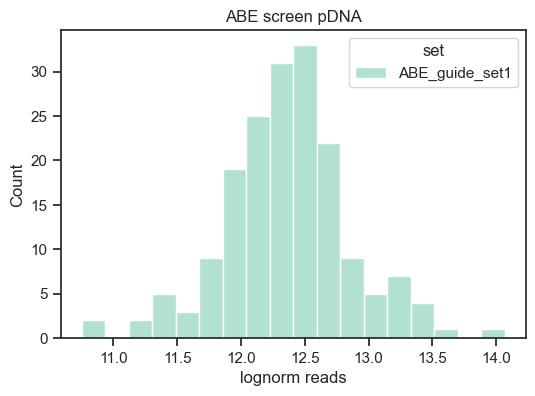

In [77]:
plt.subplots(figsize=(6,4))

sns.histplot(data = filtered_lognorms, x = 'CP1986_pDNA', hue = 'set')
plt.title('ABE screen pDNA')
plt.xlabel('lognorm reads')

## Calculate LFCs

In [79]:
lfc_df_temp = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='CP1986_pDNA', target_cols=['A549_RDA867_CP1986A_CP1988A',
                                                                                                    'A549_RDA867_CP1986B_CP1988A',
                                                                                                    'A549_RDA867_CP1986B_CP1988B',])

lfc_df = lfc_df_temp[['sgrna_sequence','A549_RDA867_CP1986A_CP1988A','A549_RDA867_CP1986B_CP1988A','A549_RDA867_CP1986B_CP1988B']]

In [80]:
lfc_df = lfc_df_temp[['sgrna_sequence','A549_RDA867_CP1986A_CP1988A','A549_RDA867_CP1986B_CP1988A','A549_RDA867_CP1986B_CP1988B']]

In [81]:
lfc_df = lfc_df.set_index("sgrna_sequence")

In [82]:
#rename columns
lfc_df_2 = lfc_df.rename(columns={"A549_RDA867_CP1986A_CP1988A": "SGL rep A +\n" "STL rep A",
                                "A549_RDA867_CP1986B_CP1988A": "SGL rep B +\n" "STL rep A",
                                "A549_RDA867_CP1986B_CP1988B": "SGL rep B +\n" "STL rep B"})

## Replicate correlation heatmaps

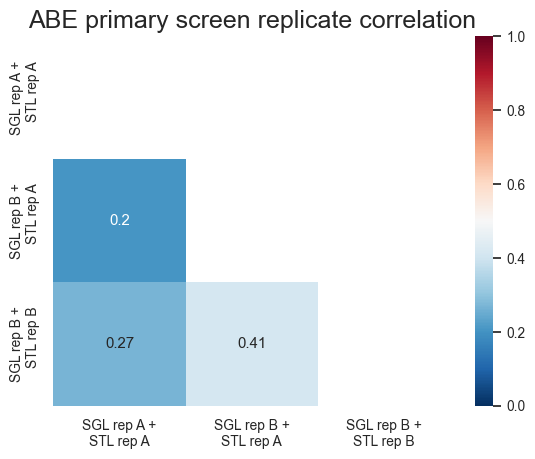

In [83]:
sns.set(font_scale=0.9)
sns.set_style(rc = {'axes.facecolor': 'white'})

lfc_correlations = lfc_df_2.corr()
matrix = np.triu(lfc_correlations)

sns.heatmap(lfc_correlations, cmap='RdBu_r',
               vmin=0, vmax=1, annot=True, mask=matrix)
t = plt.title('ABE primary screen replicate correlation', x=0.5, fontsize=18)

## Calculate z-scores

In [84]:
abe_lfcs_2 = lfc_df.reset_index().copy()
abe_lfcs_2 = abe_lfcs_2[['sgrna_sequence','A549_RDA867_CP1986A_CP1988A','A549_RDA867_CP1986B_CP1988A','A549_RDA867_CP1986B_CP1988B']]
abe_lfcs_long = pd.melt(abe_lfcs_2, id_vars=['sgrna_sequence'], value_vars=['A549_RDA867_CP1986A_CP1988A',
                                                                            'A549_RDA867_CP1986B_CP1988A',
                                                                            'A549_RDA867_CP1986B_CP1988B'])
#get mean and sd to z score
abe_mean = abe_lfcs_long['value'].mean()
abe_sd = abe_lfcs_long['value'].std()

#find average lfc per guide + z score it
abe_lfcs_2 = abe_lfcs_2.set_index('sgrna_sequence')
abe_lfcs_2['avg'] = abe_lfcs_2.mean(axis=1)
abe_lfcs_2['avg_z'] = (abe_lfcs_2['avg'] - abe_mean) / abe_sd

#rank by average lfc Z score
abe_lfcs_2 = abe_lfcs_2.sort_values(by = 'avg_z', ascending = False).reset_index(drop = False)
abe_lfcs_2['rank'] = abe_lfcs_2.index + 1

#long form
abe_lfcs_long = pd.melt(abe_lfcs_2, id_vars=['sgrna_sequence','avg','avg_z','rank'], value_vars=['A549_RDA867_CP1986A_CP1988A',
                                                                                           'A549_RDA867_CP1986B_CP1988A',
                                                                                           'A549_RDA867_CP1986B_CP1988B'])
abe_lfcs_long['z-score_per_rep'] = (abe_lfcs_long['value'] - abe_mean) / abe_sd

#nominate guides based on per replicate z>2
abe_lfcs_long['Nominated'] = np.where(abe_lfcs_long['z-score_per_rep'] >1.96, 'Nominated','Not nominated')
validation_nominated_sgrnas = abe_lfcs_long[abe_lfcs_long['Nominated']=='Nominated']['sgrna_sequence'].unique()

## Graphing all LFCs

In [85]:
abe_lfcs_2['Nominated'] = np.where(abe_lfcs_2['sgrna_sequence'].isin(validation_nominated_sgrnas), 'Nominated','Not nominated')

abe_lfcs_max = abe_lfcs_2.set_index('sgrna_sequence')
abe_lfcs_max = abe_lfcs_max.drop(['Nominated', 'rank', 'avg_z'], axis=1)
abe_lfcs_max['lfc_max'] = abe_lfcs_max.max(axis=1)
abe_lfcs_max['max_z'] = (abe_lfcs_max['lfc_max'] - abe_mean) / abe_sd

abe_lfcs_max['max rank'] = abe_lfcs_max['max_z'].rank(ascending=False)
abe_lfcs_max = abe_lfcs_max.sort_values(by=['max rank'])

In [86]:
abe_lfcs_max = abe_lfcs_max.reset_index(drop=False)
abe_lfcs_max = pd.merge(abe_lfcs_max,abe_lfcs_2[['sgrna_sequence', 'Nominated']],on='sgrna_sequence', how='left')

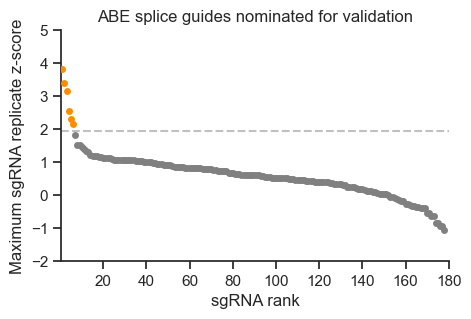

In [87]:
#maximum zscore as rank, highlighting nominated guides
gpp.set_aesthetics()

fig, ax = plt.subplots(figsize=(5,3))

colors={'Nominated': 'darkorange', 'Not nominated':'gray'}

s = sns.stripplot(x='max rank', y='max_z', data=abe_lfcs_max,size =5, hue = 'Nominated', palette = colors, legend=False)

plt.axhline(y=1.96, color = 'silver', linestyle = '--')
    
plt.xticks(ticks=range(19,180,20), labels=(20, 40, 60, 80, 100, 120, 140, 160, 180))
ax.set_xlabel('sgRNA rank')
ax.set_ylabel('Maximum sgRNA replicate z-score')
t = plt.title('ABE splice guides nominated for validation')
ax.set_ylim(-2, 5)

sns.despine()